In [4]:
import random
import gym
import numpy as np
from IPython.display import clear_output
from time import sleep
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha = 0.0005
gamma = 0.99

class VNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcV1 = torch.nn.Linear(4, 64)
        self.fcV2 = torch.nn.Linear(64, 64)
        self.fcV3 = torch.nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.fcV1(x)
        x = torch.nn.functional.tanh(x)
        x = self.fcV2(x)
        x = torch.nn.functional.tanh(x)
        x = self.fcV3(x)
        return x
    
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fcA1 = torch.nn.Linear(4, 64)
        self.fcA2 = torch.nn.Linear(64, 64)
        self.fcA3 = torch.nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.fcA1(x)
        x = torch.nn.functional.tanh(x)
        x = self.fcA2(x)
        x = torch.nn.functional.tanh(x)
        x = self.fcA3(x)  
        x = torch.nn.functional.softmax(x, dim=-1)
        return x
    
    
# network and optimizer
pi = PolicyNetwork().to(device)
pi_old = PolicyNetwork().to(device)
pi_old.load_state_dict(pi.state_dict())
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=alpha)

V = VNetwork().to(device)
V_optimizer = torch.optim.Adam(V.parameters(), lr=alpha)    
    

def gen_episode():
    states = []
    actions = []
    rewards = []
    state = env.reset() 
    done = False
    score = 0
    while not done:
        
        probs = pi_old(torch.FloatTensor(state).to(device))
        action = torch.multinomial(probs, 1).item()

        next_state, reward, done, info = env.step(action)  # take a random action
        if done:
            reward = -10
            env.close()
        score = score + reward
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)    
        state = next_state
    return states, actions, rewards, score

def G(t):
    G = 0
    for tau in range(t, len(rewards)):
        G = G + gamma**(tau - t) * rewards[tau]
    return G
        
env = gym.make('CartPole-v1')

scores = [];
episode = 0
MAX_EPISODES = 100
while episode < MAX_EPISODES:  # episode loop
    states, actions, rewards, score = gen_episode()
    scores.append(score)
    loss1 = 0
    loss2 = 0
    for t in range(0, len(rewards)-1):
        s = states[t]
        a = actions[t]

        s=torch.FloatTensor(s).to(device)
        a=torch.tensor(a, dtype=torch.int8).to(device)
        #a=torch.IntTensor(a).to(device)
        R=torch.FloatTensor([G(t)]).to(device)
        
        with torch.no_grad():
            m = 1/pi_old(s)[a]
            A = R-V(s)
            
        ratio = pi(s)[a]*m
        surr1 = ratio * (gamma**t) * A
        eps_clip= 0.2
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * (gamma**t) * A        
        loss1 = loss1 -torch.min(surr1, surr2)
        loss2 = loss2 + (R - V(s))**2
    loss1 = loss1/len(rewards)
    loss2 = loss2/len(rewards)
    

    
    V_optimizer.zero_grad()
    loss2.backward()
    for _ in range(20):
        V_optimizer.step()


    pi_optimizer.zero_grad()
    loss1.backward()
    for _ in range(20):
        pi_optimizer.step()
    # Copy new weights into old policy:
    pi_old.load_state_dict(pi.state_dict())    
    
    
    
    print('episode: {}, reward: {:.1f}'.format(episode, score))
    episode = episode + 1
    



episode: 0, reward: 14.0
episode: 1, reward: 16.0
episode: 2, reward: 20.0
episode: 3, reward: 26.0
episode: 4, reward: 5.0
episode: 5, reward: 30.0
episode: 6, reward: 35.0
episode: 7, reward: 15.0
episode: 8, reward: 47.0
episode: 9, reward: 37.0
episode: 10, reward: 22.0
episode: 11, reward: 40.0
episode: 12, reward: 37.0
episode: 13, reward: 43.0
episode: 14, reward: 19.0
episode: 15, reward: 34.0
episode: 16, reward: 31.0
episode: 17, reward: 22.0
episode: 18, reward: 34.0
episode: 19, reward: 34.0
episode: 20, reward: 51.0
episode: 21, reward: 118.0
episode: 22, reward: 55.0
episode: 23, reward: 45.0
episode: 24, reward: 93.0
episode: 25, reward: 151.0
episode: 26, reward: 125.0
episode: 27, reward: 109.0
episode: 28, reward: 106.0
episode: 29, reward: 64.0
episode: 30, reward: 428.0
episode: 31, reward: 185.0
episode: 32, reward: 138.0
episode: 33, reward: 55.0
episode: 34, reward: 97.0
episode: 35, reward: 62.0
episode: 36, reward: 98.0
episode: 37, reward: 150.0
episode: 38, r

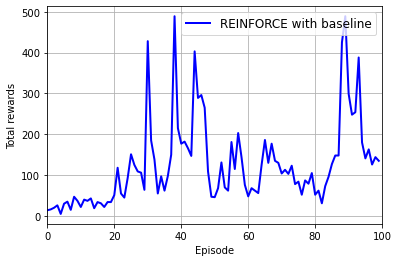

In [5]:


plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'REINFORCE with baseline')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
plt.xlim(0, MAX_EPISODES)
plt.grid(True)


In [6]:
# TEST   
episode = 0
state = env.reset()    
while episode < 5:  # episode loop
    env.render()
    probs = pi(torch.FloatTensor(state).to(device))     
    action = torch.multinomial(probs, 1).item()
    next_state, reward, done, info = env.step(action)  # take a random action
    state = next_state
    sleep(0.01)
    if done:
        reward = -10
        env.close()
    score = score + reward
    if done:
        episode = episode + 1
        print('Episode: {} Score: {}'.format(episode, score))
        state = env.reset()
env.close()    

C:\Users\hopel\anaconda3\envs\openai\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode: 1 Score: 326.0
Episode: 2 Score: 472.0
Episode: 3 Score: 678.0
Episode: 4 Score: 820.0
Episode: 5 Score: 1028.0
